In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Load data

In [19]:
df = pd.read_csv('data_final.csv', sep=';')
data_dict = pd.read_excel("Dictionnaire_final.xlsx").set_index("NOM").to_dict(orient='index')
data_dict = {k.replace("\xa0", ""): v['DESCRIPTION'] for k, v in data_dict.items()}

# Handle missing values

In [20]:
# McGill College / Sainte-Catherine 's distance from downtown is missing, assuming that is because it is 0
df["ln_distdt"] = df["ln_distdt"].fillna(0)

## Drop invalid entries

In [21]:
# We assume pi == 0 is a missing value, since no accidents can occur if no pedestrians are present
print(df[df["pi"] == 0].shape[0])

# We drop the rows with pi == 0, as we cannot impute the missing values
df = df[df["pi"] > 0]


25


# Create new features

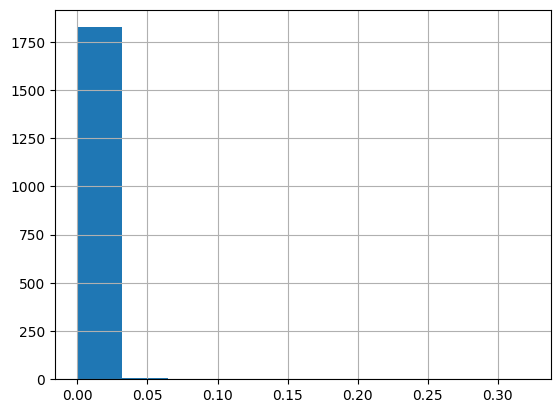

In [22]:
df["acc_rate"] =  df["acc"] / df["pi"]
df["ln_acc_rate"] = df["acc"] / np.log(df["pi"])
df["acc_rate"].hist()

# Reorder columns so that pi, acc and acc_rate are next to each other
first_cols = ["rue_1", "rue_2", "int_no", "borough", "acc", "pi", "acc_rate", "ln_acc_rate"]
df = df[first_cols + [c for c in df.columns if c not in first_cols]]

# Plot distribution

In [26]:
from ipywidgets import interact, interactive, fixed, interact_manual

def show_data(column="acc", ax=None):
    if df[column].dtype == object:
        df[column].value_counts().sort_index().plot(kind='bar', ax=ax)
    else:
        df[column].hist(ax=ax)
    ax.set_title(f'Distribution of {column}')

def show_relation(column1="pi", ax=None):
    if df[column1].dtype == object:    
        df.groupby(column1)['acc'].mean().plot(kind='bar', ax=ax)
        ax.set_ylabel('Mean accidents')
    else:
        df.plot.scatter(x=column1, y='acc', ax=ax)
        # show ab line
        x = df[column1]
        y = df['acc']
        A = np.vstack([x, np.ones(len(x))]).T
        m, c = np.linalg.lstsq(A, y, rcond=None)[0]
        ax.plot(x, m*x + c, 'r', label='Fitted line')
    ax.set_title(f'Relation between {column1} and acc')

def display_variable(column="acc"):
    print(f"{column} - {data_dict.get(column, column)}")
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    show_data(column, ax=axes[0])
    show_relation(column, ax=axes[1])
    plt.show()

interact(display_variable, column=[(f"{c} - {data_dict.get(c, c)}", c) for c in list(df.columns)])


interactive(children=(Dropdown(description='column', index=4, options=(('rue_1 -  first street of the intersec…

<function __main__.display_variable(column='acc')>

In [10]:
if False:
    import geopandas as gpd
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.y, df.x))
    gdf.plot(column="borough", legend=True, figsize=(10, 10))

# Inspect specific intersections

In [11]:
df.sort_values("acc_rate", ascending=False).head(20)

,rue_1,rue_2,int_no,borough,acc,pi,acc_rate,ln_acc_rate,x,y,street_1,street_2,date_,all_pedest,fi,fli,fri,fti,cli,cri,cti,ln_pi,ln_fi,ln_fli,ln_fri,ln_fti,ln_cli,ln_cri,ln_cti,tot_crossw,number_of_,avg_crossw,tot_road_w,median,green_stra,half_phase,any_ped_pr,ped_countd,lt_protect,lt_restric,lt_prot_re,parking,north_veh,north_ped,east_veh,east_ped,south_veh,south_ped,west_veh,west_ped,total_lane,of_exclusi,any_exclus,commercial,curb_exten,all_red_an,new_half_r,distdt,ln_distdt,traffic_10000,ped_100,Unnamed: 59,Unnamed: 60
37,Laurier,Pie-IX,860,Rosemont-La-Petite-Patrie,1,3.108282,0.321721,0.881780,299678.37500,5046468.5,Laurier,Pie-IX,15/12/2008,0,34586.183594,586.080750,1088.082397,32912.019531,0.000000,15.373031,0.000000e+00,1.134070,10.451210,6.373458,6.992172,10.401593,0.000000,2.732615,0.000000,64.800003,3,21.600000,59.500000,1,0,1,1,1,1,1,1,0.0,19340.664062,0.000000,0.000000,3.108282,14444.293945,0.000000,801.224304,0.000000,6,0,0,0,0,0,1,6259.475098,8.741852,3.458618,0.031083,NaN,NaN
1047,Dickson,Notre-Dame,971,Mercier-Hochelaga-Maisonneuve,5,26.274242,0.190300,1.529712,302962.21875,5047229.5,Dickson,Notre-Dame,01/04/2009,1,49099.164062,11322.154297,13478.662109,24298.347656,17157.427734,150872.343750,3.192103e+05,3.268589,10.801597,9.334517,9.508863,10.098164,9.750186,11.924189,12.673606,113.400002,4,28.400000,77.900002,1,0,0,1,1,1,0,1,0.0,12172.635742,0.000000,13175.617188,0.000000,1714.648438,13.137121,22036.263672,13.137121,7,2,1,1,0,0,0,7929.388184,8.978332,4.909916,0.262742,NaN,NaN
194,Oxford,Upper Lachine,66,C¶te-des-Neiges-Notre-Dame-de-Graces,2,11.138784,0.179553,0.829726,296231.75000,5036562.5,Oxford,Upper Lachine,09/09/2009,0,26979.718750,880.321960,7887.385742,18212.011719,2801.633301,25101.681641,5.795990e+04,2.410433,10.202841,6.780288,8.973020,9.809837,7.937958,10.130690,10.967507,57.900002,4,14.500000,47.900002,0,0,0,0,0,0,1,1,1.0,11025.518555,0.000000,0.000000,3.182510,15954.200195,3.182510,0.000000,4.773764,4,0,0,0,0,0,0,4743.628906,8.464558,2.697972,0.111388,NaN,NaN
204,Lorimier,Notre-Dame/Viger,717,Ville-Marie,1,6.802073,0.147014,0.521587,301215.59375,5042539.5,Lorimier,Notre-Dame/Viger,14/11/2008,0,49676.554688,4128.524414,11171.629883,34376.398438,7007.946777,1341.340088,7.525140e+04,1.917227,10.813288,8.325675,9.321133,10.445126,8.854800,7.201424,11.228590,92.500000,2,46.299999,67.199997,1,0,0,0,0,1,1,1,0.0,15083.845703,5.101555,29701.505859,1.700518,4891.201172,0.000000,0.000000,0.000000,7,1,1,0,0,0,0,3039.092041,8.019314,4.967656,0.068021,NaN,NaN
114,Notre-Dame,Viau,777,Mercier-Hochelaga-Maisonneuve,1,10.547572,0.094809,0.424467,302622.62500,5046310.5,Notre-Dame,Viau,14/05/2009,0,38559.820312,2738.459717,1002.737610,34818.621094,16471.562500,5553.125488,1.575002e+05,2.355896,10.559966,7.915151,6.910489,10.457908,9.709391,8.622116,11.967182,83.199997,4,20.799999,68.099998,1,0,1,1,1,1,0,1,0.0,0.000000,6.027184,16391.689453,4.520388,79.995766,0.000000,22088.132812,0.000000,6,2,1,0,0,0,1,6959.786133,8.847904,3.855982,0.105476,NaN,NaN
263,Henri-Bourassa,Sartelon,8892,Saint-Laurent,1,11.494981,0.086994,0.409515,286792.37500,5041346.0,Henri-Bourassa,Sartelon,08/04/2009,0,38007.714844,864.167175,703.846558,36439.703125,5348.853516,1155.814697,3.590346e+05,2.441911,10.545544,6.761766,6.556560,10.503414,8.584638,7.052561,12.791174,94.699997,3,31.600000,61.900002,1,1,0,1,1,1,1,1,0.0,850.481262,1.642140,16200.202148,8.210701,0.000000,0.000000,20957.031250,1.642140,7,1,1,1,0,0,0,12505.362305,9.433913,3.800771,0.114950,NaN,NaN
1193,La Vérendrye,Trinitaires,1811,Sud-Ouest,4,61.438156,0.065106,0.971338,297554.81250,5033933.0,La VÚrendrye,Trinitaires,07/07/2009,0,40694.714844,8592.347656,8714.385742,23387.980469,199316.656250,301617.531250,2.535731e+05,4.118031,10.613853,9.058627,9.072731,10.059978,12.202650,12.616915,12.443408,95.000000,3,31.700001,56.299999,1,0,0,0,0,0,0,0,0.0,8675.084961,50.596127,18870.482422,10.842027,0.000000,0.000000,13149.145508,0.000000,3,0,0,0,0,0,0,6514.700195,8.781816,4.069471,0.6143

# Drop superfluous columns

In [12]:
# Drop superfluous columns
df = df.drop(columns=["Unnamed: 59", "Unnamed: 60"])
# Drop descriptive columns
df = df.drop(columns=["street_1", "street_2", "date_", "x", "y"])

# Drop columns that are transformations of other columns
# log_columns = [c for c in df.columns if c.startswith("ln_")]
# divided_columns = ["traffic_10000", "ped_100"]
# df = df.drop(columns=log_columns + divided_columns)

In [13]:
# Duplicates?
print(df["int_no"].value_counts().sort_values().tail(5))
df[df["int_no"] == 9151]

int_no
938     1
1249    1
128     1
539     1
9151    2
Name: count, dtype: int64


,rue_1,rue_2,int_no,borough,acc,pi,acc_rate,ln_acc_rate,all_pedest,fi,fli,fri,fti,cli,cri,cti,ln_pi,ln_fi,ln_fli,ln_fri,ln_fti,ln_cli,ln_cri,ln_cti,tot_crossw,number_of_,avg_crossw,tot_road_w,median,green_stra,half_phase,any_ped_pr,ped_countd,lt_protect,lt_restric,lt_prot_re,parking,north_veh,north_ped,east_veh,east_ped,south_veh,south_ped,west_veh,west_ped,total_lane,of_exclusi,any_exclus,commercial,curb_exten,all_red_an,new_half_r,distdt,ln_distdt,traffic_10000,ped_100
731,Langelier,P,9151,St-LÚonard,0,894.321106,0.000000,0.000000,0,21885.785156,1797.271240,1911.182861,18177.332031,367918.562500,358592.75,5179895.0,6.796065,9.993593,7.494025,7.555478,9.807931,12.815617,12.789943,15.460295,70.500000,4,17.6,62.400002,1,0,0,0,0,0,0,0,0.0,9022.216797,103.190895,1742.424927,193.709229,10397.59375,173.795197,723.549316,423.625793,4,0,0,7,0,0,0,10801.348633,9.287426,2.188579,8.943211
756,Jean-Talon,Mainville,9151,St-LÚonard,1,1124.394653,0.000889,0.142349,0,12923.561523,590.416504,740.914795,11592.229492,193910.265625,330928.50,6889527.5,7.025000,9.466807,6.380828,6.607886,9.358090,12.175151,12.709658,15.745513,53.700001,4,13.4,37.400002,0,0,0,0,0,0,0,0,0.5,764.068420,530.071777,6766.636230,223.094177,0.00000,0.000000,5392.856445,371.228729,4,0,0,0,0,0,0,9239.489258,9.131242,1.292356,11.243946


# Standardize data types

In [14]:
# Convert columns with only 2 unique values to binary
binary_columns = [c for c in df.columns if df[c].nunique() == 2]
df[binary_columns] = df[binary_columns].astype(bool)

In [15]:
df.to_csv("data_final_cleaned.csv", index=False)

# Check correlation

In [ ]:
import seaborn as sns
import utils

df = utils.load_data()
df = utils.prepare_data(df)

def plot_corr_heatmap(y_column="acc"):
    corr = df.corr()[y_column].sort_values(ascending=False).to_frame()
    plt.figure(figsize=(12, 10))

    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Correlation with {y_column}')
    plt.show()

interact(plot_corr_heatmap, y_column=df.columns)

interactive(children=(Dropdown(description='y_column', index=77, options=('pi', 'all_pedest', 'fi', 'fli', 'fr…

<function __main__.plot_corr_heatmap(y_column='acc')>